In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torch
import numpy as np
from torch.autograd import Variable 


In [2]:
mobi_data = pd.read_csv("../data/Mobi_System_Data_2020.csv", compression='zip').dropna()
geo_data = pd.read_csv('../data/geocodings.csv',index_col=0)
data = mobi_data.merge(geo_data.rename({'lat':'Departure lat','long':'Departure long'},axis=1),left_on='Departure station',right_on='address').drop('address',axis=1)
data = data.merge(geo_data.rename({'lat':'Return lat','long':'Return long'},axis=1),left_on='Return station',right_on='address').drop('address',axis=1)
data.shape
# data = data.loc[data["Departure postal code"].str.startswith("V6")]
print(data.columns)
data["time"] = pd.to_datetime(data["Departure"], format="%Y-%m-%d %H:%M:%S")
data["hour"] = data["time"].dt.hour
data["day"] = data["time"].dt.day
data["month"] = data["time"].dt.month
data["year"] = data["time"].dt.year

# train_data = data[["year", "month", "day", "hour", "Departure lat", "Departure long"]]
features_departure = ["month", "day", "hour", "Departure lat", "Departure long", "is_park", "is_translink"]
counts_data_departure = data.groupby(["month", "day", "hour", "Departure lat", "Departure long", "Departure station"]).size().reset_index(name='counts')


Index(['Unnamed: 0', 'Departure', 'Return', 'Bike', 'Departure station',
       'Return station', 'Membership type', 'Covered distance (m)',
       'Duration (sec.)', 'Departure battery voltage (mV)',
       'Return battery voltage (mV)', 'Departure temperature (C)',
       'Return temperature (C)', 'Stopover duration (sec.)',
       'Number of stopovers', 'postal_code_x', 'Departure lat',
       'Departure long', 'postal_code_y', 'Return lat', 'Return long'],
      dtype='object')


In [3]:
# Preprocess for stations
stations = data[["Departure lat", "Departure long", "Departure station"]].drop_duplicates()
stations = stations.rename(columns={"Departure lat": "lat", "Departure long": "long", "Departure station": "station"})
parks = pd.read_csv('../data/processed/parks.csv',index_col=0)
population = pd.read_csv("../data/processed/population.csv")
translink_stops = pd.read_csv("../data/processed/translink_stops.csv")

print(stations)

              lat        long                                   station
0       49.283227 -123.120523  0099 Vancouver Art Gallery - North Plaza
338     49.280876 -123.130680                   0126 Thurlow & Pendrell
367     49.262141 -123.101961                          0074 10th & Main
369     49.274566 -123.121817          0004 Yaletown-Roundhouse Station
396     49.265605 -123.152566                        0109 7th & Arbutus
...           ...         ...                                       ...
45935   43.390667  -79.763537          0981 Workshop - Service Complete
123967  49.021526 -122.383601             0985 Yard - Long Term Storage
448055  42.872283  -81.291349                   0995 Workshop - On Deck
471395  45.971435  -73.483220               0986 Quebec Yard - Serviced
571528  45.506058  -73.563392             0985 Quebec Yard - To Service

[221 rows x 3 columns]


In [4]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371
    return c * r

In [5]:
import json
for s in stations.iterrows():
    lat, long = s[1][0], s[1][1]
    stations.loc[s[0], "is_park"] = 0
    for p in parks.iterrows():
        coor = p[1][1]
        [p_lat_str, p_long_str] = p[1][1][1:-1].split(", ")
        p_lat, p_long = float(p_lat_str[1:-1]), float(p_long_str[1:-1])
        distance = haversine(lat, long, p_lat, p_long)
        if distance < 0.5:
            stations.loc[s[0], "is_park"] = 1
            break
    stations.loc[s[0], "is_translink"] = 0
    for t in translink_stops.iterrows():
        coor = t[1][1]
        [t_lat_str, t_long_str] = t[1][1][1:-1].split(", ")
        t_lat, t_long = float(t_lat_str), float(t_long_str)
        distance = haversine(lat, long, t_lat, t_long)
        if distance < 0.25:
            stations.loc[s[0], "is_translink"] = 1
            break


221


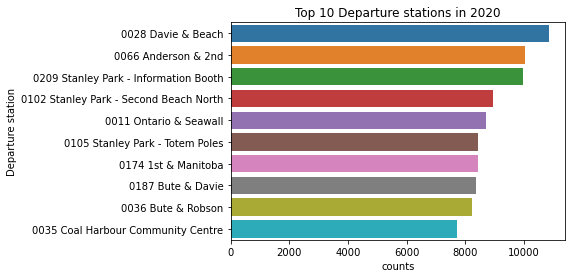

In [6]:
# stations = data[["Departure lat", "Departure long", "Departure station"]].drop_duplicates()
max_lat, min_lat = stations["lat"].max(), stations["lat"].min()
max_long, min_long = stations["long"].max(), stations["long"].min()
batch = stations.shape[0]
print(batch)
predict_data_departure = pd.DataFrame(data={
    "month": [], 
    "day": [], 
    "hour": [], 
    "Departure lat": [],
    "Departure long": [],
    "is_park": [],
    "is_translink": [],
    "Departure station": []})
for row in stations.iterrows():
    time = pd.date_range('2020-01-01', periods=8760, freq='H')

    station_data = pd.DataFrame(data={"time": time})
    station_data["hour"] = station_data["time"].dt.hour
    station_data["day"] = station_data["time"].dt.day
    station_data["month"] = station_data["time"].dt.month
    station_data["Departure lat"] = (row[1]["lat"] - min_lat) / (max_lat - min_lat)
    station_data["Departure long"] = (row[1]["long"] - min_long) / (max_long - min_long)
    station_data["Departure station"] = row[1]["station"]
    station_data["is_park"] = row[1]["is_park"]
    station_data["is_translink"] = row[1]["is_translink"]
    station_data = station_data.drop(columns=["time"])
    
    predict_data_departure = pd.concat([predict_data_departure, station_data])

train_data = predict_data_departure.merge(counts_data_departure[["month", "day", "hour", "Departure station", "counts"]], how="left", left_on=["month", "day", "hour", "Departure station"], right_on=["month", "day", "hour", "Departure station"])
train_data["counts"] = train_data["counts"].fillna(0)

top_stations = train_data[["Departure station", "counts"]].groupby("Departure station").sum().reset_index()
top_stations = top_stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="Departure station", data=top_stations)
ax.set(title='Top 10 Departure stations in 2020')

train_data["month"] = train_data["month"] / 12
train_data["day"] = train_data["day"] / 31
train_data["hour"] = train_data["hour"] / 23
# train_data = train_data.sort_values(by="Departure station")
x = train_data[features_departure]
y = train_data["counts"]
    



In [7]:
from xgboost import XGBRegressor
model_departure = XGBRegressor()
model_departure.fit(x, y)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [8]:
predict_data_departure = pd.DataFrame(data={
    "month": [], 
    "day": [], 
    "hour": [], 
    "Departure lat": [],
    "Departure long": [],
    "is_park": [],
    "is_translink": []})
for row in stations.iterrows():
    time = pd.date_range('2022-05-01', periods=168, freq='H')

    station_data = pd.DataFrame(data={"time": time})
    station_data["hour"] = station_data["time"].dt.hour / 23
    station_data["day"] = station_data["time"].dt.day / 31
    station_data["month"] = station_data["time"].dt.month / 12
    station_data["Departure lat"] = (row[1]["lat"] - min_lat) / (max_lat - min_lat)
    station_data["Departure long"] = (row[1]["long"] - min_long) / (max_long - min_long)
    station_data["Departure station"] = row[1]["station"]
    station_data["is_park"] = row[1]["is_park"]
    station_data["is_translink"] = row[1]["is_translink"]
    station_data = station_data.drop(columns=["time"])
    
    predict_data_departure = pd.concat([predict_data_departure, station_data])

predict_data_departure["counts"] = model_departure.predict(predict_data_departure[features_departure])
predict_data_departure["counts"] = predict_data_departure["counts"].clip(lower=0.000001)
print(predict_data_departure["counts"].sum())

9553.106


<AxesSubplot:title={'center':'# of Departure for each hour'}, xlabel='hour'>

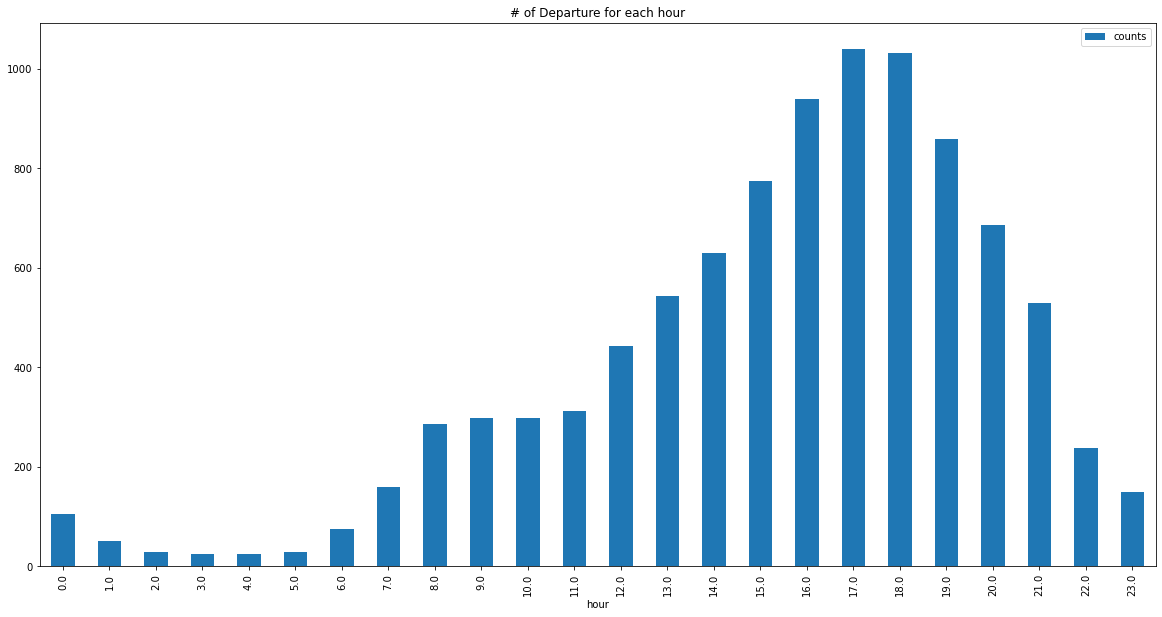

In [9]:
hours = predict_data_departure.loc[:, ["hour", "counts"]]
hours["hour"] = (hours["hour"] * 23).round()
hours = hours.groupby("hour").sum()
# hours.plot.line(figsize=(20, 10)).set_ylabel("# of bikes");
hours.plot(kind='bar', figsize=(20, 10), title="# of Departure for each hour")
# print(hours)

In [10]:
# month = predict_data_departure.loc[:, ["month", "counts"]]
# month["month"] = (month["month"] * 12).round()
# month = month.groupby("month").sum()
# month.plot(kind='bar', figsize=(20, 10), title="# of Departure for each month");

[Text(0.5, 1.0, 'Top 10 departure stations')]

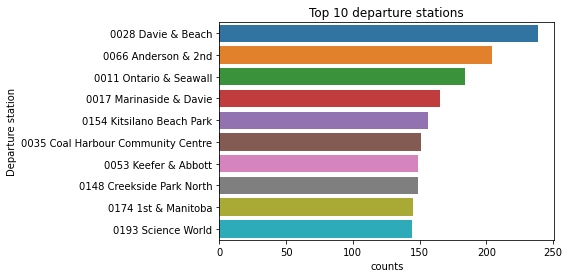

In [11]:
top_stations = predict_data_departure[["Departure station", "counts"]].groupby("Departure station").sum().reset_index()
top_stations = top_stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="Departure station", data=top_stations)
ax.set(title="Top 10 departure stations")
# stations.sort_values(by="counts", ascending= False).head(10).plot(kind='bar', figsize=(20, 10));

221
(1935960, 8)
(1935960, 9)


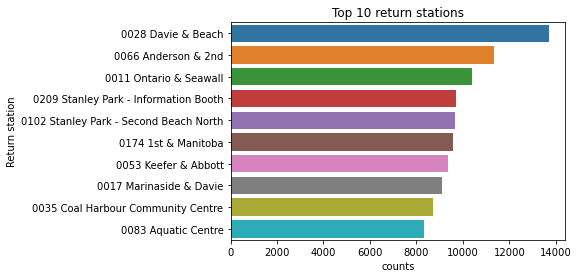

In [12]:
features_return = ["month", "day", "hour", "Return lat", "Return long", "is_park", "is_translink"]
# counts_data = data.groupby(["month", "day", "hour", "Return lat", "Return long", "Return station", "Duration (sec.)"]).size().reset_index(name='counts')
counts_data_return = data.loc[:, ["month", "day", "hour", "Return lat", "Return long", "Return station", "Duration (sec.)"]]
counts_data_return["Duration (sec.)"] = (counts_data_return["Duration (sec.)"] / 3600).astype(int)
counts_data_return["hour"] = counts_data_return["hour"] + counts_data_return["Duration (sec.)"]
counts_data_return["day"] = counts_data_return["day"] + (counts_data_return["hour"] / 24).astype(int)
counts_data_return["hour"] = counts_data_return["hour"].mod(24)
counts_data_return = counts_data_return.drop(columns=["Duration (sec.)"])
counts_data_return = counts_data_return.groupby(["month", "day", "hour", "Return lat", "Return long", "Return station"]).size().reset_index(name='counts')
# print(counts_data.shape)
# stations = data[["Return lat", "Return long", "Return station"]].drop_duplicates()
# max_lat, min_lat = stations["Return lat"].max(), stations["Return lat"].min()
# max_long, min_long = stations["Return long"].max(), stations["Return long"].min()
# batch = stations.shape[0]
print(batch)
predict_data_return = pd.DataFrame(data={
    "month": [], 
    "day": [], 
    "hour": [], 
    "Return lat": [],
    "Return long": []})
for row in stations.iterrows():
    time = pd.date_range('2020-01-01', periods=8760, freq='H')

    station_data = pd.DataFrame(data={"time": time})
    station_data["hour"] = station_data["time"].dt.hour
    station_data["day"] = station_data["time"].dt.day
    station_data["month"] = station_data["time"].dt.month
    station_data["Return lat"] = (row[1]["lat"] - min_lat) / (max_lat - min_lat)
    station_data["Return long"] = (row[1]["long"] - min_long) / (max_long - min_long)
    station_data["Return station"] = row[1]["station"]
    station_data["is_park"] = row[1]["is_park"]
    station_data["is_translink"] = row[1]["is_translink"]
    station_data = station_data.drop(columns=["time"])
    
    predict_data_return = pd.concat([predict_data_return, station_data])
print(predict_data_return.shape)
train_data = predict_data_return.merge(counts_data_return[["month", "day", "hour", "Return station", "counts"]], how="left", on=["month", "day", "hour", "Return station"])
train_data["counts"] = train_data["counts"].fillna(0)

top_stations = train_data[["Return station", "counts"]].groupby("Return station").sum().reset_index()
top_stations = top_stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="Return station", data=top_stations)
ax.set(title='Top 10 return stations')

train_data["month"] = train_data["month"] / 12
train_data["day"] = train_data["day"] / 31
train_data["hour"] = train_data["hour"] / 23
# train_data = train_data.sort_values(by="Departure station")
print(train_data.shape)
x = train_data[features_return]
y = train_data["counts"]
    

In [13]:
from xgboost import XGBRegressor
model_return = XGBRegressor()
model_return.fit(x, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [14]:
predict_data_return = pd.DataFrame(data={
    "month": [], 
    "day": [], 
    "hour": [], 
    "Return lat": [],
    "Return long": [],})
for row in stations.iterrows():
    time = pd.date_range('2022-05-01', periods=168, freq='H')

    station_data = pd.DataFrame(data={"time": time})
    station_data["hour"] = station_data["time"].dt.hour / 23
    station_data["day"] = station_data["time"].dt.day / 31
    station_data["month"] = station_data["time"].dt.month / 12
    station_data["Return lat"] = (row[1]["lat"] - min_lat) / (max_lat - min_lat)
    station_data["Return long"] = (row[1]["long"] - min_long) / (max_long - min_long)
    station_data["Return station"] = row[1]["station"]
    station_data["is_park"] = row[1]["is_park"]
    station_data["is_translink"] = row[1]["is_translink"]
    station_data = station_data.drop(columns=["time"])
    
    predict_data_return = pd.concat([predict_data_return, station_data])

predict_data_return["counts"] = model_return.predict(predict_data_return[features_return])
predict_data_return["counts"] = predict_data_return["counts"].clip(lower=0.000001)
print(predict_data_return["counts"].sum())

9411.013


<AxesSubplot:title={'center':'# of Return for each hour'}, xlabel='hour'>

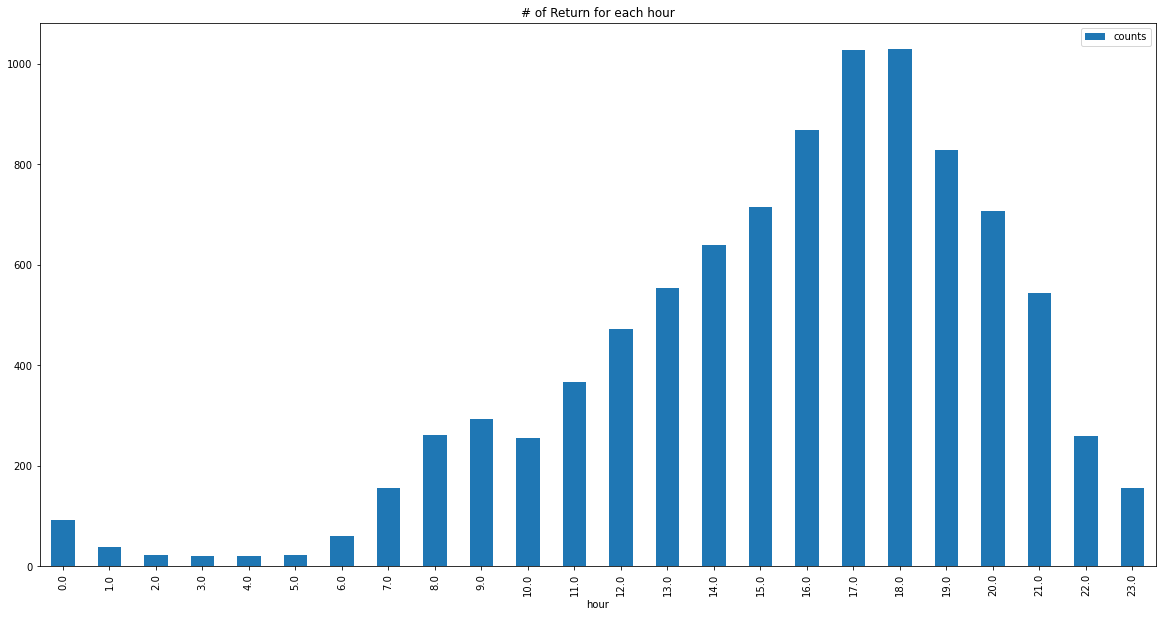

In [15]:
hours = predict_data_return.loc[:, ["hour", "counts"]]
hours["hour"] = (hours["hour"] * 23).round()
hours = hours.groupby("hour").sum()
# hours.plot.line(figsize=(20, 10)).set_ylabel("# of bikes");
hours.plot(kind='bar', figsize=(20, 10), title="# of Return for each hour")
# print(hours)

In [16]:
# month = predict_data_return.loc[:, ["month", "counts"]]
# month["month"] = (month["month"] * 12).round()
# month = month.groupby("month").sum()
# month.plot(kind='bar', figsize=(20, 10), title="# of Return for each month");

[Text(0.5, 1.0, 'Top 10 return stations')]

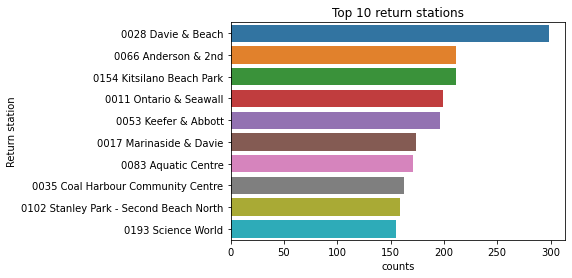

In [17]:
top_stations = predict_data_return[["Return station", "counts"]].groupby("Return station").sum().reset_index()
top_stations = top_stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="Return station", data=top_stations)
ax.set(title='Top 10 return stations')

In [18]:
predict_data = predict_data_departure.merge(
    predict_data_return, 
    left_on=['Departure station', "month", "day", "hour"],
    right_on=['Return station', "month", "day", "hour"])
print(predict_data)
predict_data["ratio"] = predict_data["counts_x"] / predict_data["counts_y"]
predict_data = predict_data.rename(columns={'Departure lat': 'lat', 'Departure long': 'long', 'Departure station': 'station'})
predict_data = predict_data[["lat", "long", "station", "month", "day", "hour", "ratio", "counts_x", "counts_y"]]
predict_data["month"] = (predict_data["month"] * 12).astype(int)
predict_data["day"] = (predict_data["day"] * 31).astype(int)
predict_data["hour"] = (predict_data["hour"] * 23).astype(int)

          month       day      hour  Departure lat  Departure long  is_park_x  \
0      0.416667  0.032258  0.000000       0.693601        0.000627        1.0   
1      0.416667  0.032258  0.043478       0.693601        0.000627        1.0   
2      0.416667  0.032258  0.086957       0.693601        0.000627        1.0   
3      0.416667  0.032258  0.130435       0.693601        0.000627        1.0   
4      0.416667  0.032258  0.173913       0.693601        0.000627        1.0   
...         ...       ...       ...            ...             ...        ...   
37123  0.416667  0.225806  0.826087       0.284948        0.841722        0.0   
37124  0.416667  0.225806  0.869565       0.284948        0.841722        0.0   
37125  0.416667  0.225806  0.913043       0.284948        0.841722        0.0   
37126  0.416667  0.225806  0.956522       0.284948        0.841722        0.0   
37127  0.416667  0.225806  1.000000       0.284948        0.841722        0.0   

       is_translink_x      

In [27]:
ratio_data = predict_data.loc[
    (predict_data["ratio"] > 1) & ((predict_data["counts_x"] > 1) | (predict_data["counts_y"] > 2))].sort_values(by="ratio", ascending=False).head(10)
print(ratio_data)


            lat      long                                      station  month  \
22917  0.695631  0.000018  0103 Stanley Park - Third Beach Parking Lot      5   
3298   0.693613  0.000447                            0050 Bute & Comox      5   
3346   0.693613  0.000447                            0050 Bute & Comox      5   
3274   0.693613  0.000447                            0050 Bute & Comox      5   
3322   0.693613  0.000447                            0050 Bute & Comox      5   
3250   0.693613  0.000447                            0050 Bute & Comox      5   
7087   0.693293  0.000373                          0088 Harwood & Bute      5   
22893  0.695631  0.000018  0103 Stanley Park - Third Beach Parking Lot      5   
3272   0.693613  0.000447                            0050 Bute & Comox      5   
22941  0.695631  0.000018  0103 Stanley Park - Third Beach Parking Lot      5   

       day  hour         ratio  counts_x  counts_y  
22917    3    21  1.125609e+06  1.125609  0.000001  
32